# Pose Detection with OpenPose

This notebook uses an open source project [CMU-Perceptual-Computing-Lab/openpose](https://github.com/CMU-Perceptual-Computing-Lab/openpose.git) to detect/track multi person poses on a given youtube video.

For other deep-learning Colab notebooks, visit [tugstugi/dl-colab-notebooks](https://github.com/tugstugi/dl-colab-notebooks).


## Install OpenPose

In [ ]:
import os
from os.path import exists, join, basename, splitext
from IPython.display import YouTubeVideo

git_repo_url = 'https://github.com/CMU-Perceptual-Computing-Lab/openpose.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # see: https://github.com/CMU-Perceptual-Computing-Lab/openpose/issues/949
  # install new CMake becaue of CUDA10
  !wget -q https://cmake.org/files/v3.13/cmake-3.13.0-Linux-x86_64.tar.gz
  !tar xfz cmake-3.13.0-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local
  # clone openpose
  !git clone -q --depth 1 $git_repo_url
  !sed -i 's/execute_process(COMMAND git checkout master WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/execute_process(COMMAND git checkout f019d0dfe86f49d1140961f8c7dec22130c83154 WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/g' openpose/CMakeLists.txt
  # install system dependencies
  !apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev
  # install python dependencies
  !pip install -q youtube-dl
  # build openpose
  !cd openpose && rm -rf build || true && mkdir build && cd build && cmake .. && make -j`nproc`
  

Selecting previously unselected package libgflags2.2.
(Reading database ... 160706 files and directories currently installed.)
Preparing to unpack .../00-libgflags2.2_2.2.1-1_amd64.deb ...
Unpacking libgflags2.2 (2.2.1-1) ...
Selecting previously unselected package libgflags-dev.
Preparing to unpack .../01-libgflags-dev_2.2.1-1_amd64.deb ...
Unpacking libgflags-dev (2.2.1-1) ...
Selecting previously unselected package libgoogle-glog0v5.
Preparing to unpack .../02-libgoogle-glog0v5_0.3.5-1_amd64.deb ...
Unpacking libgoogle-glog0v5 (0.3.5-1) ...
Selecting previously unselected package libgoogle-glog-dev.
Preparing to unpack .../03-libgoogle-glog-dev_0.3.5-1_amd64.deb ...
Unpacking libgoogle-glog-dev (0.3.5-1) ...
Selecting previously unselected package libhdf5-serial-dev.
Preparing to unpack .../04-libhdf5-serial-dev_1.10.0-patch1+docs-4_all.deb ...
Unpacking libhdf5-serial-dev (1.10.0-patch1+docs-4) ...
Selecting previously unselected package libleveldb1v5:amd64.
Preparing to unpack ...

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp '/content/drive/My Drive/Colab Notebooks/datasets/pose_iter_440000.caffemodel' './openpose/models/pose/coco/'

## Detect poses on a test video

We are going to detect poses on the following youtube video:

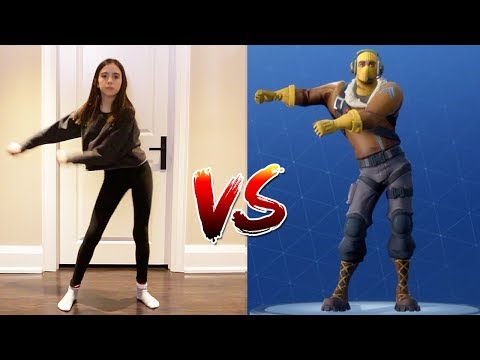

In [ ]:
YOUTUBE_ID = 'RXABo9hm8B8'


YouTubeVideo(YOUTUBE_ID)

Download the above youtube video, cut the first 5 seconds and do the pose detection on that 5 seconds:

In [ ]:
!rm -rf youtube.mp4
# download the youtube with the given ID
!youtube-dl -f 'bestvideo[ext=mp4]' --output "youtube.%(ext)s" https://www.youtube.com/watch?v=$YOUTUBE_ID
# cut the first 5 seconds
!ffmpeg -y -loglevel info -i youtube.mp4 -t 5 video.mp4
# detect poses on the these 5 seconds
!rm openpose.avi
!cd openpose && ./build/examples/openpose/openpose.bin --video ../video.mp4 --write_json ./output/ --display 0  --write_video ../openpose.avi
# convert the result into MP4
!ffmpeg -y -loglevel info -i openpose.avi output.mp4

[youtube] RXABo9hm8B8: Downloading webpage
[download] Destination: youtube.mp4
[download] 100% of 116.07MiB in 00:02
ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis

Finally, visualize the result:

In [ ]:
def show_local_mp4_video(file_name, width=640, height=480):
  import io
  import base64
  from IPython.display import HTML
  video_encoded = base64.b64encode(io.open(file_name, 'rb').read())
  return HTML(data='''<video width="{0}" height="{1}" alt="test" controls>
                        <source src="data:video/mp4;base64,{2}" type="video/mp4" />
                      </video>'''.format(width, height, video_encoded.decode('ascii')))

show_local_mp4_video('output.mp4', width=960, height=720)

Output hidden; open in https://colab.research.google.com to view.

# Customize

In [ ]:
!./openpose/build/examples/openpose/openpose.bin --help

openpose.bin: Warning: SetUsageMessage() never called

  Flags from /build/gflags-6Vsjoz/gflags-2.2.1/src/gflags.cc:
    -flagfile (load flags from file) type: string default: ""
    -fromenv (set flags from the environment [use 'export FLAGS_flag1=value'])
      type: string default: ""
    -tryfromenv (set flags from the environment if present) type: string
      default: ""
    -undefok (comma-separated list of flag names that it is okay to specify on
      the command line even if the program does not define a flag with that
      name.  IMPORTANT: flags in this list that have arguments MUST use the
      flag=value format) type: string default: ""

  Flags from /build/gflags-6Vsjoz/gflags-2.2.1/src/gflags_completions.cc:
    -tab_completion_columns (Number of columns to use in output for tab
      completion) type: int32 default: 80
    -tab_completion_word (If non-empty, HandleCommandLineCompletions() will
      hijack the process and attempt to do bash-style command line flag
  

In [ ]:
# detect poses on the these 5 seconds
!rm openpose.avi
!cd openpose && ./build/examples/openpose/openpose.bin --video ../IMG_6709.mp4 --write_json ./output/ --display 0  --write_video ../openpose.avi --model_pose COCO
# convert the result into MP4
!ffmpeg -y -loglevel info -i openpose.avi output.mp4

Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...

Error:
VideoCapture (IP camera/video) could not be opened for path: '../IMG_6709.mp4'. If it is a video path, is the path correct?

Coming from:
- /content/openpose/src/openpose/producer/videoCaptureReader.cpp:VideoCaptureReader():54
- /content/openpose/src/openpose/producer/videoCaptureReader.cpp:VideoCaptureReader():58
- /content/openpose/src/openpose/producer/producer.cpp:createProducer():475
- /content/openpose/include/openpose/wrapper/wrapperAuxiliary.hpp:configureThreadManager():1221
- /content/openpose/include/openpose/wrapper/wrapper.hpp:exec():424
ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnut

In [ ]:
def show_local_mp4_video(file_name, width=640, height=480):
  import io
  import base64
  from IPython.display import HTML
  video_encoded = base64.b64encode(io.open(file_name, 'rb').read())
  return HTML(data='''<video width="{0}" height="{1}" alt="test" controls>
                        <source src="data:video/mp4;base64,{2}" type="video/mp4" />
                      </video>'''.format(width, height, video_encoded.decode('ascii')))

show_local_mp4_video('output.mp4', width=960, height=720)

Output hidden; open in https://colab.research.google.com to view.

# Trim_Dataset_self 처리

In [ ]:
!rm openpose.avi
!cd openpose && ./build/examples/openpose/openpose.bin --video ../assault-kick_0.mp4 --write_json ./output/ --display 0  --write_video ../openpose.avi --model_pose COCO # assault 영상 처리
# convert the result into MP4
!ffmpeg -y -loglevel info -i openpose.avi output.mp4

rm: cannot remove 'openpose.avi': No such file or directory
Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
Empty frame detected, frame number 77 of 85. In /content/openpose/src/openpose/producer/producer.cpp:checkFrameIntegrity():290
Empty frame detected, frame number 77 of 85. In /content/openpose/src/openpose/producer/producer.cpp:checkFrameIntegrity():290
Empty frame detected, frame number 77 of 85. In /content/openpose/src/openpose/producer/producer.cpp:checkFrameIntegrity():290
OpenPose demo successfully finished. Total time: 25.316396 seconds.
ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresa

In [ ]:
def show_local_mp4_video(file_name, width=640, height=480):
  import io
  import base64
  from IPython.display import HTML
  video_encoded = base64.b64encode(io.open(file_name, 'rb').read())
  return HTML(data='''<video width="{0}" height="{1}" alt="test" controls>
                        <source src="data:video/mp4;base64,{2}" type="video/mp4" />
                      </video>'''.format(width, height, video_encoded.decode('ascii')))

show_local_mp4_video('output.mp4', width=960, height=720)

In [ ]:
# 개인 구글 드라이브 경로 연결
v = '../drive/MyDrive/Colab\ Notebooks/datasets/trim_dataset_self/assault-falldown_0.mp4'

# 경로 내 assault-falldown_0.mp4 잡는지 확인 (성공)
!cd openpose && ./build/examples/openpose/openpose.bin --video $v --write_json ../Outputs/ --display 0 --render_pose 0 --model_pose COCO

Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
^C


In [ ]:
import glob
v_paths = glob.glob('/content/drive/My Drive/Colab Notebooks/datasets/trim_dataset_self/*.mp4')

# 리스트로 처리해보고자 listdir 이용, sort 후에 openpose 적용하려 했지만, $v에는 '파일 이름'이 아닌 '경로'가 들어가야해서 실패
# list_vi = os.listdir('/content/drive/My Drive/Colab Notebooks/datasets/trim_dataset_self')
# list_vi.sort()
# print(list_vi)

# for avi in list_vi:
#   print(avi[0])

print(v_paths[0])
# print(len('/content/drive/My Drive/Colab Notebooks/'))
v_paths = ['../drive/MyDrive/Colab\ Notebooks/' + v[40:] for v in v_paths]
# v_paths
# # detect poses!rm openpose.avi 

# 경로 내 영상에서 프레임별로 skeleton json 정보만 빼온 후 Outputs 파일에 저장 
for v in v_paths:
  !cd openpose && ./build/examples/openpose/openpose.bin --video $v --write_json ../Outputs/ --display 0 --render_pose 0 --model_pose COCO # --video가 -video로 바뀌어 처음에 실패함


/content/drive/My Drive/Colab Notebooks/datasets/trim_dataset_self/assault-kick_7.mp4
Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
Empty frame detected, frame number 88 of 97. In /content/openpose/src/openpose/producer/producer.cpp:checkFrameIntegrity():290
Empty frame detected, frame number 88 of 97. In /content/openpose/src/openpose/producer/producer.cpp:checkFrameIntegrity():290
Empty frame detected, frame number 88 of 97. In /content/openpose/src/openpose/producer/producer.cpp:checkFrameIntegrity():290
OpenPose demo successfully finished. Total time: 28.669522 seconds.
Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
Empty frame detected, frame number 95 of 104. In /content/openpose/src/openpose/producer/producer.cpp:checkFrameIntegrity():290
Empty frame

In [ ]:
!zip ./Outputs.zip ./Outputs/*

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  adding: Outputs/assault-punch_7_000000000044_keypoints.json (deflated 60%)
  adding: Outputs/assault-punch_7_000000000045_keypoints.json (deflated 59%)
  adding: Outputs/assault-punch_7_000000000046_keypoints.json (deflated 59%)
  adding: Outputs/assault-punch_7_000000000047_keypoints.json (deflated 59%)
  adding: Outputs/assault-punch_7_000000000048_keypoints.json (deflated 59%)
  adding: Outputs/assault-punch_7_000000000049_keypoints.json (deflated 58%)
  adding: Outputs/assault-punch_7_000000000050_keypoints.json (deflated 59%)
  adding: Outputs/assault-punch_7_000000000051_keypoints.json (deflated 59%)
  adding: Outputs/assault-punch_7_000000000052_keypoints.json (deflated 59%)
  adding: Outputs/assault-punch_7_000000000053_keypoints.json (deflated 59%)
  adding: Outputs/assault-punch_7_000000000054_keypoints.json (deflated 59%)
  adding: Outputs/assault-punch_7_000000000055_keypoints.json (deflated 58%)
  adding: Outputs/assault-punch_7_000000

In [ ]:
!cp ./Outputs.zip ./drive/MyDrive/Colab\ Notebooks

In [ ]:
!rm openpose.avi
!cd openpose && ./build/examples/openpose/openpose.bin --video ../outro-fighting.mp4 --write_json ./output/ --display 0  --write_video ../openpose.avi --model_pose COCO # outro 파일 처리
# convert the result into MP4
!ffmpeg -y -loglevel info -i openpose.avi output.mp4

rm: cannot remove 'openpose.avi': No such file or directory
Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
Empty frame detected, frame number 34 of 43. In /content/openpose/src/openpose/producer/producer.cpp:checkFrameIntegrity():290
Empty frame detected, frame number 34 of 43. In /content/openpose/src/openpose/producer/producer.cpp:checkFrameIntegrity():290
Empty frame detected, frame number 34 of 43. In /content/openpose/src/openpose/producer/producer.cpp:checkFrameIntegrity():290
OpenPose demo successfully finished. Total time: 12.494350 seconds.
ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresa

In [ ]:
def show_local_mp4_video(file_name, width=640, height=480):
  import io
  import base64
  from IPython.display import HTML
  video_encoded = base64.b64encode(io.open(file_name, 'rb').read())
  return HTML(data='''<video width="{0}" height="{1}" alt="test" controls>
                        <source src="data:video/mp4;base64,{2}" type="video/mp4" />
                      </video>'''.format(width, height, video_encoded.decode('ascii')))

show_local_mp4_video('output.mp4', width=960, height=720)

In [ ]:
# detect poses on the these 5 seconds
!rm openpose.avi
!cd openpose && ./build/examples/openpose/openpose.bin --video ../outro-wave.mp4 --write_json ./output/ --display 0  --write_video ../openpose.avi --model_pose COCO # outro 파일 처리
# convert the result into MP4
!ffmpeg -y -loglevel info -i openpose.avi output.mp4

Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
Empty frame detected, frame number 51 of 58. In /content/openpose/src/openpose/producer/producer.cpp:checkFrameIntegrity():290
Empty frame detected, frame number 51 of 58. In /content/openpose/src/openpose/producer/producer.cpp:checkFrameIntegrity():290
Empty frame detected, frame number 51 of 58. In /content/openpose/src/openpose/producer/producer.cpp:checkFrameIntegrity():290
OpenPose demo successfully finished. Total time: 17.435746 seconds.
ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --ena

In [ ]:
def show_local_mp4_video(file_name, width=640, height=480):
  import io
  import base64
  from IPython.display import HTML
  video_encoded = base64.b64encode(io.open(file_name, 'rb').read())
  return HTML(data='''<video width="{0}" height="{1}" alt="test" controls>
                        <source src="data:video/mp4;base64,{2}" type="video/mp4" />
                      </video>'''.format(width, height, video_encoded.decode('ascii')))

show_local_mp4_video('output.mp4', width=960, height=720)